# **Кластеризация**

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import adjusted_rand_score, silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

Загрузим датасет Boston House Prices

Описание датасета: https://www.kaggle.com/c/boston-housing

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

In [3]:
data = pd.DataFrame(boston.data, columns=boston.feature_names)

In [4]:
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [5]:
#найдем категориальные признаки
categorical_indices = list(data.nunique()[data.nunique() < 3].index)
categorical_indices

['CHAS']

Поскольку алгоритмы кластеризации определяют схожесть объектов с помощью различных метрик расстояния, поэтому с категориальными (нечисловыми) признаками будет работать плохо (для работы с категориальными признаками их необходимо преобразовать в числовые).

Чтобы алгоритм корректно работал с категориальными признаками, мы можем сделать следующее:
   1. Исключить признаки, но потерять информацию.
   2. Преобразовать признаки так, чтобы они перестали быть категориальными.
       1. Закодировать их статистиками другого, некатегориального признака.
       2. Использование методов понижения размерности, таких как MCA.
   3. Использовать подходящий алгоритм кластеризации(KModes и др.) или метрику расстояния(Gower distance и др.)

Так как число категориальных признаков в нашем датасете мало, исключим их.
Выбросим из датасета найденные ранее категориальные признаки.

In [6]:
cat_featrues = categorical_indices # список категориальных признаков. Внесите в него найденные.
data.drop(cat_featrues, axis=1, inplace=True)

Для корректной работы алгоритмов кластеризации необходимо привести признаки к одному масштабу. Отмасштабируем данные с помощью StandartScaler. 

In [7]:
scaler = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

In [8]:
scaled_data[5].mean()

-0.37433402020743584

Для визуализации датасета понизим размерность данных с помощью метода главных компонент(PCA):

In [9]:
pca = PCA(random_state=RANDOM_STATE)
embeded_data = pca.fit_transform(scaled_data)
embeded_data.shape

(506, 12)

Доля объясненной дисперсии содержится в первых 2 главных компонентах

In [10]:
ratio = pca.explained_variance_ratio_
np.round(ratio[0] + ratio[1], 2)

0.62

Визуализируем датасет:

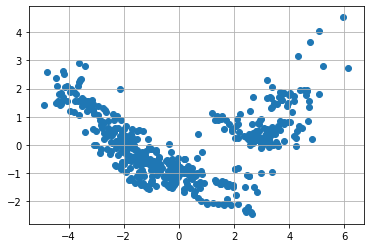

In [11]:
plt.scatter(embeded_data[:,0], embeded_data[:,1])
plt.grid()

------------------------

Попробуем выполнить кластеризацию отмасштабированных данных с помощью алгоритма KMeans со следующими параметрами:
* n_clusters = 5
* n_init = 20
* random_state = RANDOM_STATE
    
Можно вычислить сумму квадратов отклонений, центры кластеров можно найти в KMeans.cluster_centers_, но данное значение уже рассчитывается алгоритмом KMeans, найти его можно прочитав документацию: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [13]:
k_means = KMeans(n_clusters=5, n_init=20, random_state=RANDOM_STATE).fit(scaled_data)
predicted = k_means.predict(scaled_data)
np.round(k_means.inertia_, 2)

2300.59

Параметр n_init алгоритма KMeans отвечает за то, сколько раз будет запущен алгоритм с различными случайными начальными 
значениями центроид. Финальным ответом алгоритма будет тот, при начальных 
значениях центроид которого получилась минимальной сумма квадратов 
отклонений от конечных центров кластеров

Число кластеров k нам неизвестно. Подберем k по методу локтя. 

Не забудем зафиксировать **random_state=RANDOM_STATE** и **n_init = 20**.

Визуально оптимальное k не всегда может быть очевидно. Можно определить k более формальным методом:

$$D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|} \rightarrow \min\limits_k$$

In [14]:
steep = []
ks = list(range(3,15))
k_previous = KMeans(n_clusters=1, n_init=20, random_state=RANDOM_STATE).fit(scaled_data)
p_previous = k_means.predict(scaled_data)
k_current = KMeans(n_clusters=2, n_init=20, random_state=RANDOM_STATE).fit(scaled_data)
p_current = k_means.predict(scaled_data)
k_next = KMeans(n_clusters=3, n_init=20, random_state=RANDOM_STATE).fit(scaled_data)
p_next = k_means.predict(scaled_data)

for k in ks:
    steep.append(abs(k_current.inertia_ - k_next.inertia_) / abs(k_previous.inertia_ - k_current.inertia_))
    k_previous = k_current
    k_current = k_next
    k_next = KMeans(n_clusters=k+1, n_init=20, random_state=RANDOM_STATE).fit(scaled_data)
    p_next = k_means.predict(scaled_data)

best_cluster_num = min(zip(list(range(2,13)), steep), key=lambda x: x[1])[0]
best_cluster_num

2

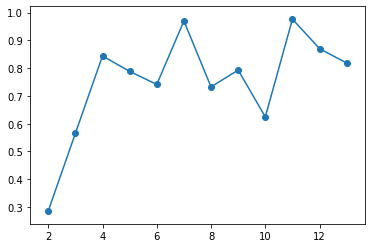

In [15]:
plt.plot(list(range(2,14)), steep)
plt.scatter(list(range(2,14)), steep)

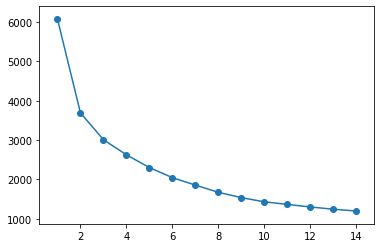

In [16]:
inertia_I = []
num_k = list(range(1,15))
for k in num_k:
    model = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE).fit(scaled_data)
    predicted = k_means.predict(scaled_data)
    inertia_I.append(model.inertia_)
plt.plot(num_k, inertia_I)
plt.scatter(num_k, inertia_I)

Оценим качество кластеризации алгоритмом KMeans с помощью метрики silhouette.

Парамтеры KMeans:
* Число кластеров k = найденному в предыдущем задании значению
* random_state=RANDOM_STATE
* n_init = 20

Визуализируем получившуюся кластеризацию. Номер кластера обозначим цветом точек.

0.38

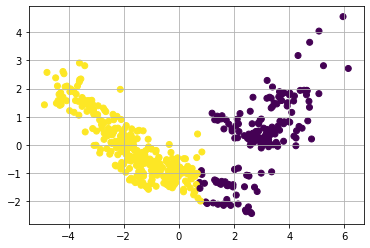

In [17]:
model = KMeans(n_clusters=best_cluster_num,
                 n_init=20,
                 random_state=RANDOM_STATE).fit(scaled_data)#найденные кластеры
clusters = model.predict(scaled_data)
plt.scatter(embeded_data[:,0], embeded_data[:,1], c = clusters)
plt.grid()
np.round(silhouette_score(scaled_data, labels=clusters,
                metric='euclidean',
                random_state=RANDOM_STATE), 2)

1. Сколько явно выделяющихся кластеров можно увидеть?
2. Исходя из визуализации и значения метрики можно ли назвать данную кластеризацию хорошей? Почему?
3. Подходит ли алгоритм KMeans для данного датасета? Почему?

1. 2 кластера
2. Исходя из метрики - нельзя, исходя из 
   визуализации ничего нельзя сказать
3. Есть и разреженные точки, и плотные точки,
   поэтому не подходит

------------------------

Попробуем применить другой алгоритм. Кластеризуем датасет с помощью DBSCAN, параметры алгоритма оставим по умолчанию. 

In [18]:
dbscan_predicted = DBSCAN().fit_predict(scaled_data)
np.unique(dbscan_predicted)

array([-1,  0,  1,  2,  3], dtype=int64)

4 кластера, -1 - шум

Визуализируем результат кластеризации. 

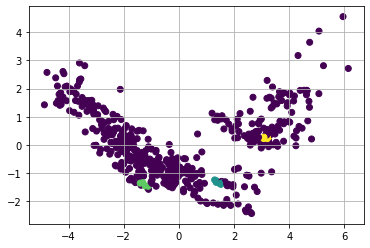

In [19]:
plt.scatter(embeded_data[:,0], embeded_data[:,1], c = dbscan_predicted)
plt.grid()

Посчитаем метрику silhouette. 

In [20]:
silhouette_score(scaled_data, labels=dbscan_predicted,
                metric='euclidean',
                random_state=RANDOM_STATE)

-0.31822452866504913

DBSCAN чувствителен к выбору параметров. Параметры по умолчанию для нашего датасета совсем не подходят.

Попробуем подобрать параметры сами.

Параметр **min_samples** - минимальное число точек в eps окрестности точки для образования кластера. Данный параметр, как правило, выбирается исходя из целей кластеризации. Чем меньше min_samples тем более разреженными могут быть кластеры, число кластеров, скорее всего, будет больше.

**Eps** - радиус окрестности, внутри которой точки считаются лежащими в одном кластере.
Параметр **eps** можно подобрать по следующему алгоритму:
   1. Выбираем некоторое значение min_samples = m.
   2. Для каждого объекта вычисляем расстояние до всех остальных объектов.
   3. Для каждого объекта запоминаем расстояния до его m-го ближайшего соседа.
   4. Сортируем расстояния и отрисовываем их на графике (ось x - номер объекта после сортировки, y - расстояние до его m-го соседа).
   5. Точка, в которой начинается резкий рост расстояния (возрастание y) скорее всего будет являться подходящим eps для данного min_samples. 

##### **Практический смысл алгоритма:** 
Плотность кластеров считаем примерно одинаковой(или ограниченной сверху), следовательно, должно быть такое расстояние EPS между двумя точками, больше которого точки считаются принадлежащим разным кластерам, а меньше - одному. 

Значение расстояния, после которого начинается резкий рост расстояний между m-тыми соседями, будем считать EPS.

Попробуем подобрать eps по описанному выше алгоритму для min_samples = 5.

In [21]:
pairwise_dist = pairwise_distances(scaled_data, metric='euclidean') #вычисляем матрицу попарных расстояний между объектами
pairwise_dist.shape

(506, 506)

Text(0.5, 1.0, 'матрица расстояний')

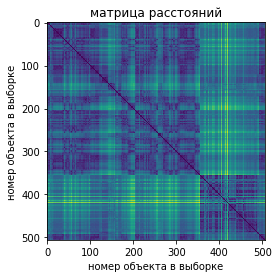

In [22]:
plt.imshow(pairwise_dist)
plt.xlabel('номер объекта в выборке')
plt.ylabel('номер объекта в выборке')
plt.title('матрица расстояний')

In [23]:
pairwise_dist.sort(axis=1) # сортируем строки матрицы по возрастанию

Text(0.5, 1.0, 'отсортированная по строкам матрица расстояний')

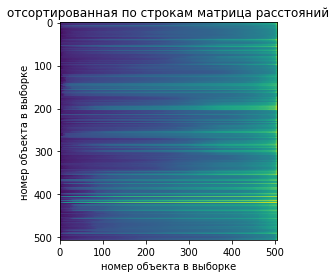

In [24]:
plt.imshow(pairwise_dist)
plt.xlabel('номер объекта в выборке')
plt.ylabel('номер объекта в выборке')
plt.title('отсортированная по строкам матрица расстояний')

In [25]:
min_samples = 5

In [26]:
dists_to_neighbour = pairwise_dist[:, min_samples].copy() # выбираем из матрицы min_samples'й столбец 
                                                            #- расстояние до соответств. соседа
dists_to_neighbour.sort() # сортируем расстояния

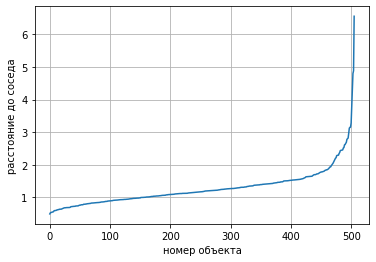

In [27]:
plt.plot(dists_to_neighbour)
plt.xlabel('номер объекта')
plt.ylabel('расстояние до соседа')
plt.grid()

Кластеризуем данные с помощью DBSCAN. Параметры алгоритма:
  * eps - значение, выбранное на предыдущем этапе.
  * min_samples = 5
  
Оцениим качество кластеризации с помощью метрики silhouette.

In [28]:
dbscan_predicted = DBSCAN(eps=2, min_samples=5).fit_predict(scaled_data)
print(silhouette_score(scaled_data, labels=dbscan_predicted,
                metric='euclidean',
                random_state=RANDOM_STATE))

0.26724833372581164


Визуализируем результат кластеризации. Можетено варьировать значение eps.

Разбиение на кластеры данного датасета алгоритмом DBSCAN лучше разбиения алгоритма KMeans, так как выделил отделенные плотные области и пометил отдаленные точки как выбросы

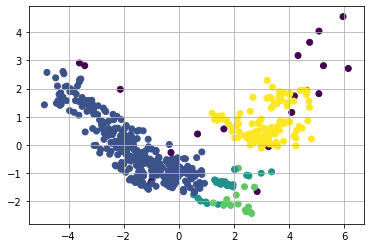

In [29]:
plt.scatter(embeded_data[:, 0], embeded_data[:, 1], c = dbscan_predicted)
plt.grid()

------------------------

Кластеризовать можно объекты, описанные не только некоторыми признаками (одна строчка - один объект), но и изображения, временные ряды и т.д. Главное, ввести правильную метрику расстояния между объектами или преобразовать объекты так, чтобы они описывались некоторыми признаками (не обязательно понятными человеку).

Например, с изображениями часто поступают так:
1. Обучают нейронную сеть(autoencoder) сжимать изображение в некоторый вектор фиксированной размерности.
2. Кластеризуют векторы обычным алгоритмом кластеризации.

Для временных рядов можно использовать тот же подход, но можно и ввести метрику расстояния(DTW, Frechet) между разными временными рядами, вычислить попарные расстояния и кластеризовать их обычным алгоритмом кластеризации. Главное,чтобы он поддерживал работу с расстояниями, а не только с исходными объектами.

Попробуем выполнить кластеризацию временных рядов.

!pip install tslearn

In [106]:
from tslearn.metrics import dtw # из библиотеки tslearn импортируем метрику dtw

**DTW (Dynamic time warping)** - алгоритм измерения схожести для временных рядов, скорость которых может изменяться.

Подробнее: 
1. https://www.cs.ucr.edu/~eamonn/RATANAMC.pdf
2. https://en.wikipedia.org/wiki/Dynamic_time_warping

Сгенерируем выборку

In [107]:
#зафиксируем random seed
np.random.seed(RANDOM_STATE)

#сгенерируем 2 типа временных рядов
series_len = 20
n_series_in_type = 30


    
#type 1. 
ts_type1 = np.zeros((n_series_in_type, series_len))
for n in range(n_series_in_type):
    series = np.sin(list(range(1,21))) + np.random.random((series_len))
    ts_type1[n,:] = series

#type 2. 
ts_type2= np.zeros((n_series_in_type, series_len))
for n in range(n_series_in_type):
    series = np.log(list(range(1,21))) + np.random.random((series_len))                                                                                                                 
    ts_type2[n,:] = series
    
#type 3. 
ts_type3= np.zeros((n_series_in_type, series_len))
for n in range(n_series_in_type):
    series = ts_type1[n] + ts_type2[n]                                                                                                                    
    ts_type3[n,:] = series
    
timeseries = np.concatenate([ts_type1, ts_type2, ts_type3]) # временные ряды
timeseries_true_clusters = np.concatenate( #реальные метки классов
    [
        np.zeros((n_series_in_type,)), 
        np.zeros((n_series_in_type,)) + 1,
        np.zeros((n_series_in_type,)) + 2
    ]
)


timeseries.shape, timeseries_true_clusters.shape

((90, 20), (90,))

Посмотрим на получившиеся ряды

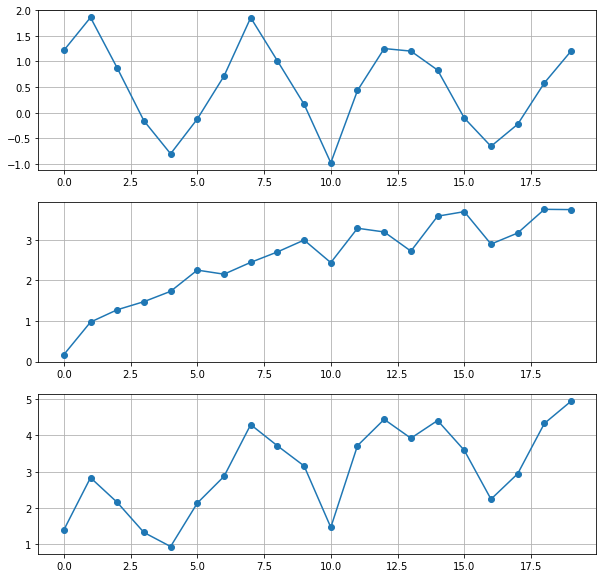

In [108]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(timeseries[0], '-o')
plt.grid()

plt.subplot(3,1,2)
plt.plot(timeseries[n_series_in_type], '-o')
plt.grid()

plt.subplot(3,1,3)
plt.plot(timeseries[n_series_in_type*2], '-o')
plt.grid()

1. Кластеризуем полученный датасет с помощью алгоритма DBSCAN(**eps=2, min_samples=20**). Для этого необходимо вычислить матрицу попарных расстояний(DTW) между рядами с помощью pairwise_distances + dtw. 
2. Оценим качество кластеризации с помощью adjusted_rand_score. Для кластеризации на матрице расстояний необходимо в конструкторе класса DBSCAN указать metric='precomputed'


In [109]:
pairwise_dist_matrix = pairwise_distances(timeseries, metric=dtw)
dbscan_predicted = DBSCAN(eps=2, min_samples=20, metric='precomputed') \
.fit_predict(pairwise_dist_matrix)
adjusted_rand_score(labels_true=timeseries_true_clusters, 
                    labels_pred=dbscan_predicted)

0.9054871412647006